This notebook explores the SDSS-MGS observational sample.

* Target selection: https://www.sdss3.org/dr8/algorithms/target_selection.php
* Data Release: https://arxiv.org/abs/0812.0649
* NYU Value-Added Catalog: http://sdss.physics.nyu.edu/vagc/
* Power spectrum analysis: https://arxiv.org/abs/astro-ph/0608636

In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import matplotlib.pyplot as plt
from os.path import join as pjoin

import astropy
from astropy.io import fits
import h5py
import pandas as pd

from scipy.spatial import ConvexHull

/tmp/ipykernel_1216600/2801976206.py:13: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Load data

In [8]:
wdir = '../MGS'
# os.listdir(wdir)

In [9]:
# Load VAGC
with fits.open(pjoin(wdir, 'lss_index.dr72.fits')) as f:
    print(f.info())
    data = f[1].data

print(data.dtype.names)

# Load Tjitske's data

cols = ['RA', 'DEC', 'Z', 'MAG', 'SURVEY', 'ZSRC']
with h5py.File(pjoin(wdir, 'tinker_SDSS_centrals_M9.7.valueadd.hdf5'), 'r') as f:
    datatj = pd.DataFrame([f[col] for col in cols], index=cols).T

Filename: ../MGS/lss_index.dr72.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      10   ()      
  1                1 BinTableHDU     43   2506754R x 13C   [D, D, E, J, J, E, J, J, E, E, J, J, J]   


None
('RA', 'DEC', 'Z', 'ZTYPE', 'SECTOR', 'FGOTMAIN', 'QUALITY', 'ISBAD', 'M', 'MMAX', 'ILSS', 'ICOMB', 'VAGC_SELECT')


## Calculate other fields

In [4]:
# mask vagc
print(len(data))
mask = (data['ILSS'] != -1) & (data['VAGC_SELECT'] == 7)
data = data[mask]

rae = 100, 270
dece = 0, 70
mask = (rae[0] < data['RA']) & (data['RA'] < rae[1]) & (dece[0] < data['DEC']) & (data['DEC'] < dece[1])
data = data[mask]

mask = (data['Z'] >=0) & (data['Z'] <= 0.4)
data = data[mask]

data = pd.DataFrame(np.array([data[col] for col in data.dtype.names]).T, columns=data.dtype.names)
print(len(data))

# mask tjitske
print(len(datatj))
mask = (rae[0] < datatj['RA']) & (datatj['RA'] < rae[1]) & (dece[0] < datatj['DEC']) & (datatj['DEC'] < dece[1])
datatj = datatj[mask]

mask = datatj['Z'] >=0
datatj = datatj[mask]

for col in ['RA' ,'DEC', 'Z', 'MAG']:
    datatj[col] = datatj[col].values.astype(float)
print(len(datatj))


2506754
608530
12344
10687


In [5]:
# calculate comoving
from astropy.cosmology import Planck15 as cosmo
from astropy import units as u

def rdz_to_xyz(ra, dec, z):
    R = cosmo.comoving_distance(z)
    ra = np.radians(ra)
    dec = np.radians(dec)
    x = R * np.cos(ra) * np.cos(dec)
    y = R * np.sin(ra) * np.cos(dec)
    z = R * np.sin(dec)
    return x, y, z

data['cX'], data['cY'], data['cZ'] = rdz_to_xyz(data['RA'], data['DEC'], data['Z'])
datatj['cX'], datatj['cY'], datatj['cZ'] = rdz_to_xyz(datatj['RA'], datatj['DEC'], datatj['Z'])

tjmask = (data['Z']<0.035) & (data['Z']>0.01)

In [6]:
# measure volume of convex hull
from scipy.spatial import ConvexHull

def measure_volume(x, y, z):
    hull = ConvexHull(np.array([x, y, z]).T)
    return hull.volume  # in (Mpc/h)^3

dvol = measure_volume(data['cX'], data['cY'], data['cZ'])
dtjvol = measure_volume(datatj['cX'], datatj['cY'], datatj['cZ'])
dmvol = measure_volume(data['cX'][tjmask], data['cY'][tjmask], data['cZ'][tjmask])

## Plot comparison

[]

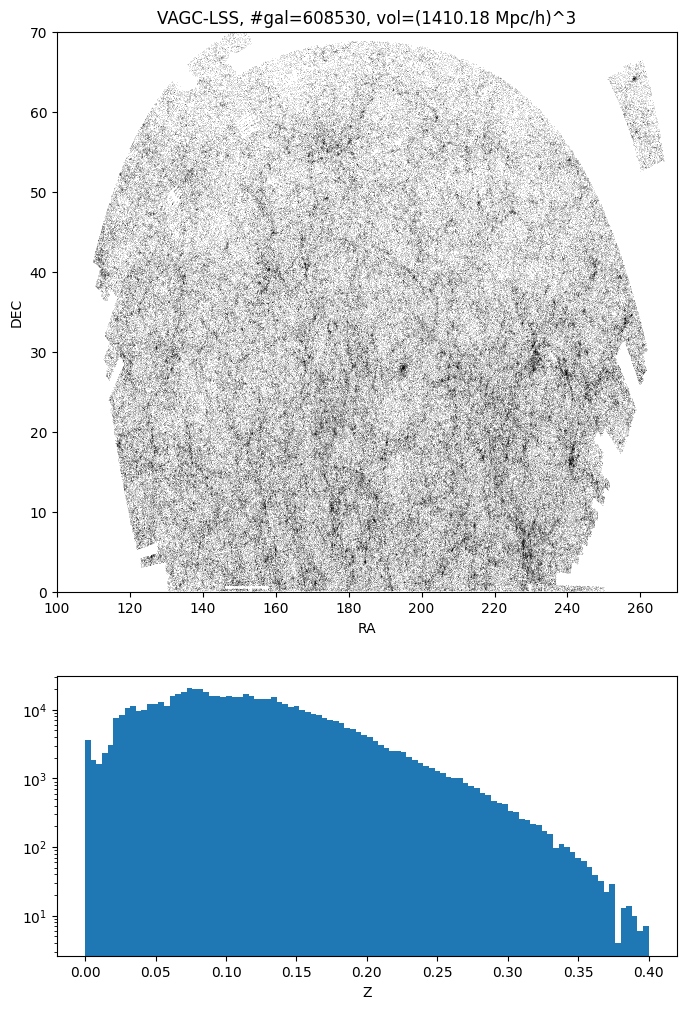

In [7]:
f = plt.figure(figsize=(8,12))
gs = f.add_gridspec(2,1, height_ratios=[1,0.5])

# vagc-lss
ax = f.add_subplot(gs[0])
ax.plot(data['RA'], data['DEC'], 'k,', alpha=0.1)
ax.set_xlim(rae)
ax.set_ylim(dece)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title(f'VAGC-LSS, #gal={len(data)}, vol=({dvol**(1/3):.2f} Mpc/h)^3')

ax = f.add_subplot(gs[1])
ax.hist(data['Z'], bins=100)
ax.set_xlabel('Z')
ax.semilogy()


Text(0.5, 0, 'Z')

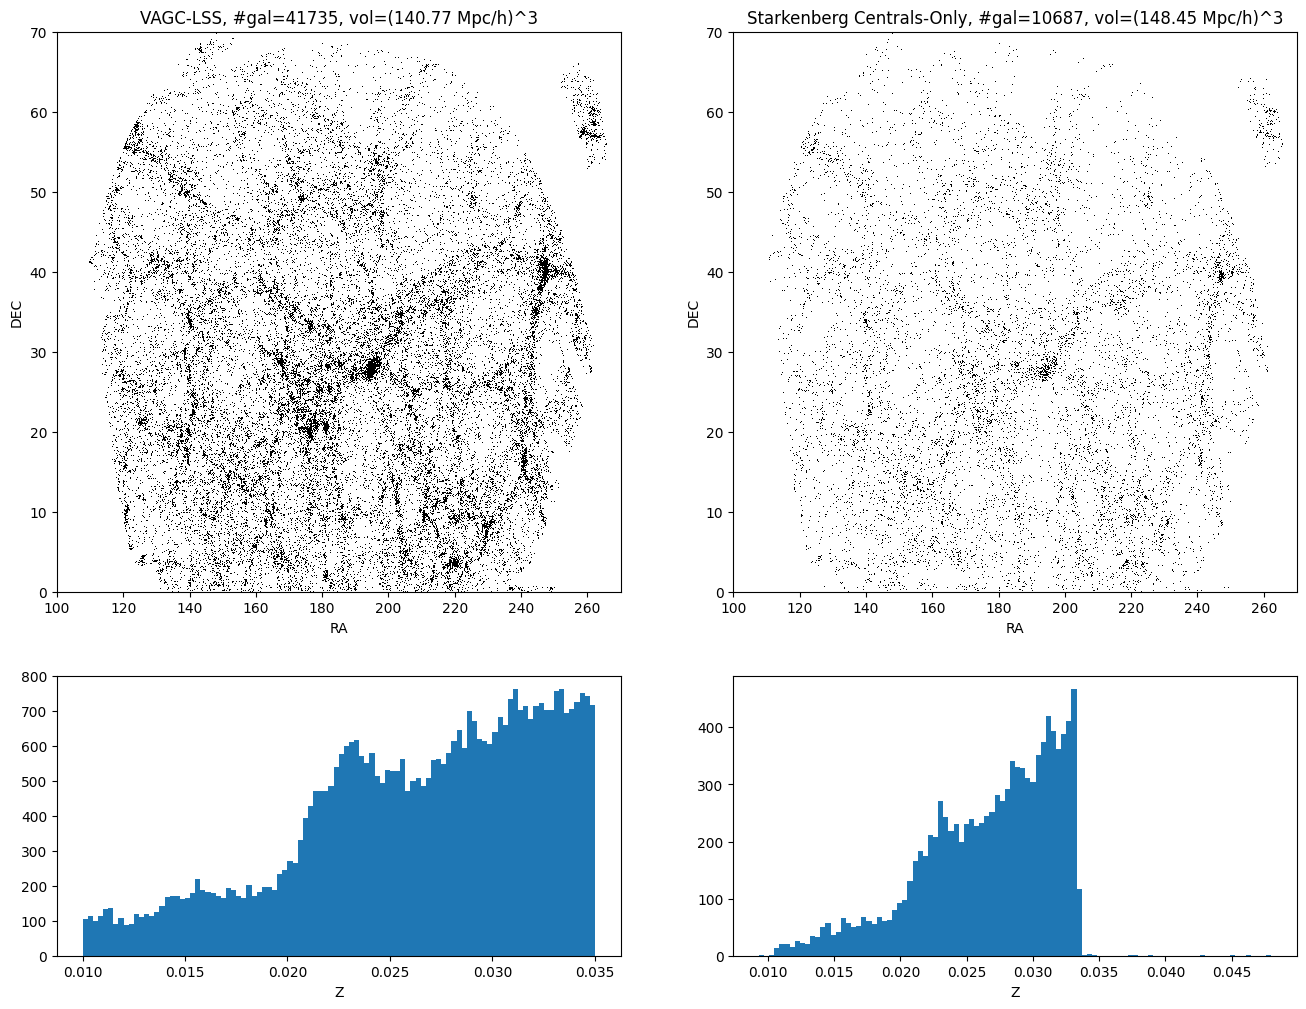

In [8]:
f = plt.figure(figsize=(16,12))
gs = f.add_gridspec(2,2, height_ratios=[1,0.5])

# vagc-lss
ax = f.add_subplot(gs[0,0])
ax.plot(data[tjmask]['RA'], data[tjmask]['DEC'], 'k,', alpha=1)
ax.set_xlim(rae)
ax.set_ylim(dece)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title(f'VAGC-LSS, #gal={len(data[tjmask])}, vol=({dmvol**(1/3):.2f} Mpc/h)^3')

ax = f.add_subplot(gs[1,0])
ax.hist(data[tjmask]['Z'], bins=100)
ax.set_xlabel('Z')
# ax.semilogy()

# tjitske
ax = f.add_subplot(gs[0,1])
ax.plot(datatj['RA'], datatj['DEC'], 'k,', alpha=1)
ax.set_xlim(rae)
ax.set_ylim(dece)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title(f'Starkenberg Centrals-Only, #gal={len(datatj)}, vol=({dtjvol**(1/3):.2f} Mpc/h)^3')

ax = f.add_subplot(gs[1,1])
ax.hist(datatj['Z'], bins=100)
ax.set_xlabel('Z')

Text(0, 0.5, 'M')

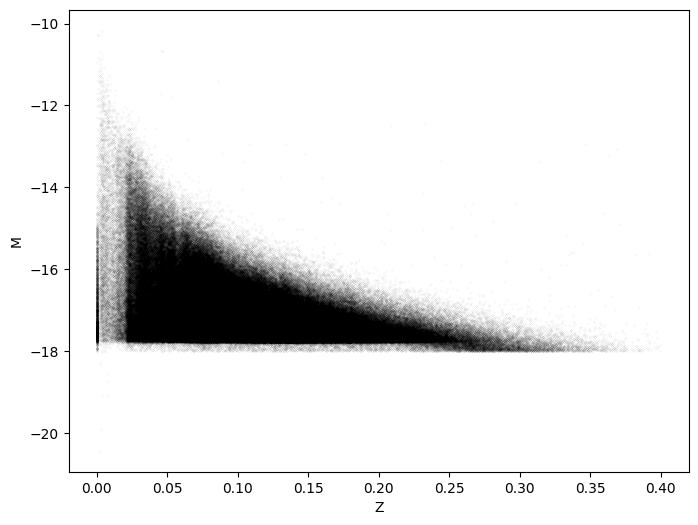

In [9]:
# plot magnitude-redshift distribution
f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(data['Z'], -data['M'], 'k.', markersize=0.1, alpha=0.5)
ax.set_xlabel('Z')
ax.set_ylabel('M')

(-20.0, 150.0)

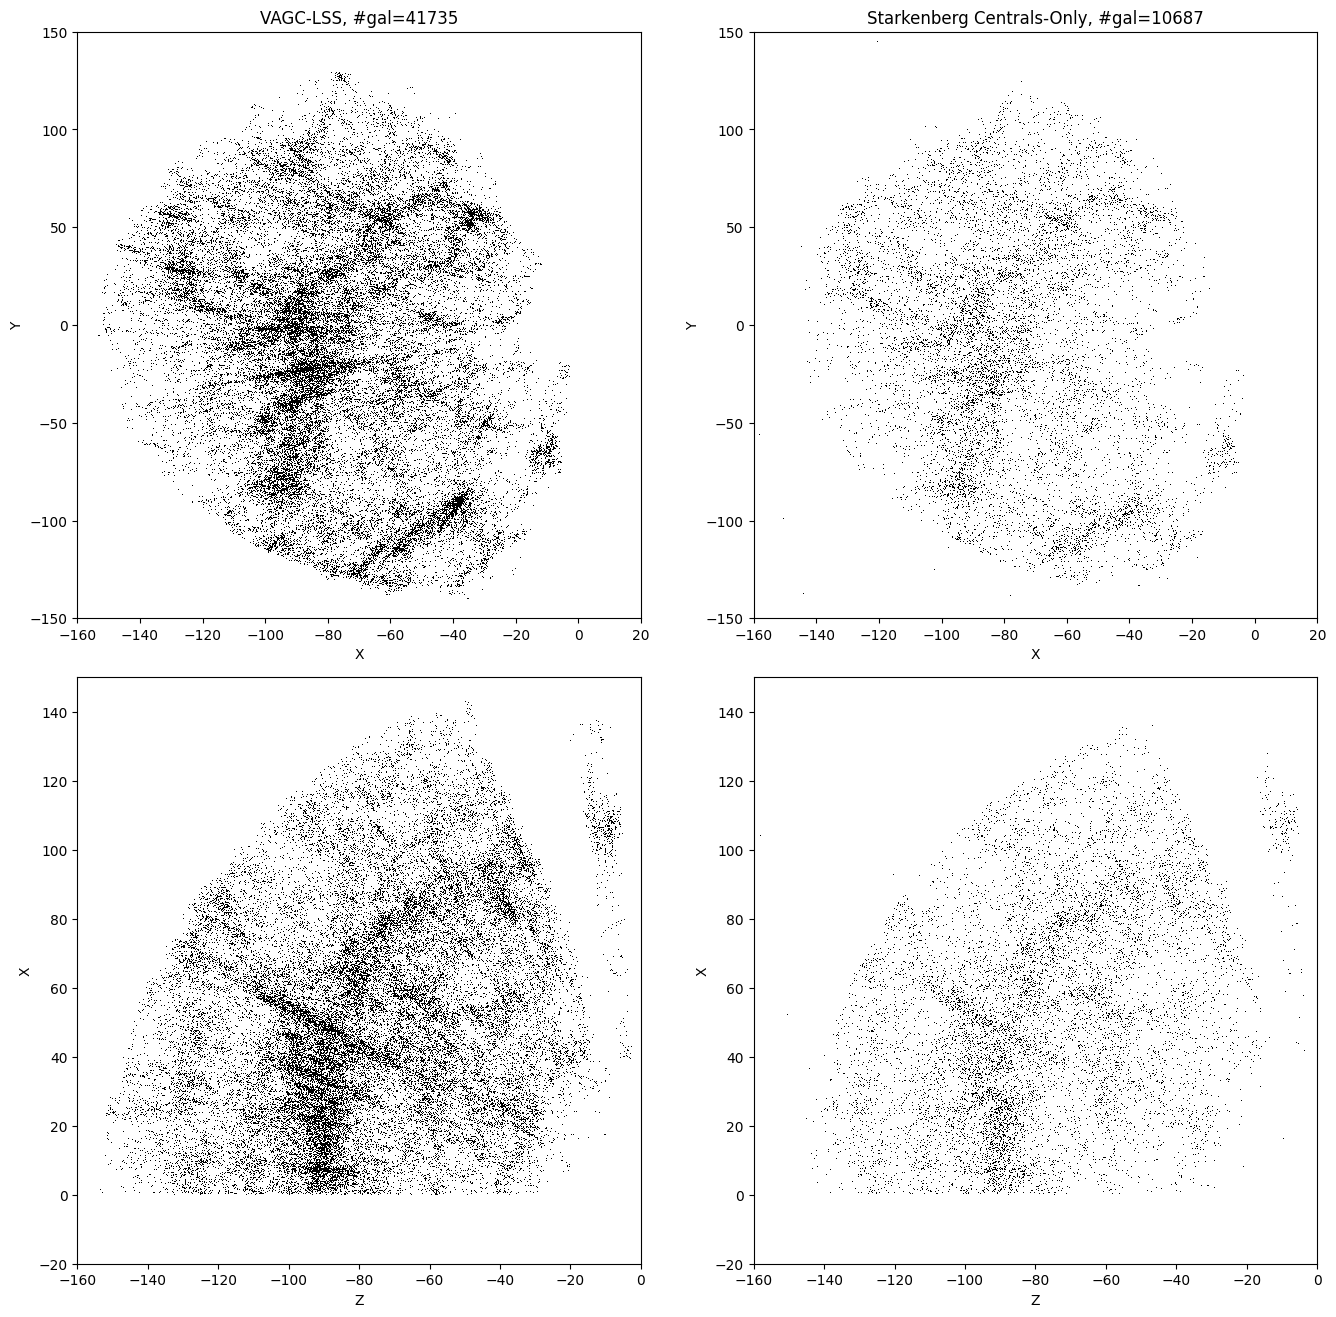

In [10]:
# plot comoving coordinates
f = plt.figure(figsize=(16,16))
gs = f.add_gridspec(2,2, height_ratios=[1,1], hspace=0.1)

# vagc-lss
ax = f.add_subplot(gs[0,0])
ax.plot(data[tjmask]['cX'], data[tjmask]['cY'], 'k,', alpha=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'VAGC-LSS, #gal={len(data[tjmask])}')
ax.set_xlim(-160, 20)
ax.set_ylim(-150, 150)

ax = f.add_subplot(gs[1,0])
ax.plot(data[tjmask]['cX'], data[tjmask]['cZ'], 'k,', alpha=1)
ax.set_xlabel('Z')
ax.set_ylabel('X')
ax.set_xlim(-160, 0)
ax.set_ylim(-20, 150)


# tjitske
ax = f.add_subplot(gs[0,1])
ax.plot(datatj['cX'], datatj['cY'], 'k,', alpha=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'Starkenberg Centrals-Only, #gal={len(datatj)}')
ax.set_xlim(-160, 20)
ax.set_ylim(-150, 150)

ax = f.add_subplot(gs[1,1])
ax.plot(datatj['cX'], datatj['cZ'], 'k,', alpha=1)
ax.set_ylabel('X')
ax.set_xlabel('Z')
ax.set_xlim(-160, 0)
ax.set_ylim(-20, 150)



## divisez en quatre

In [11]:
ramid = 187
decmid = 30

def label_quadrants(dat):
    bins = np.zeros(len(dat))
    mask = (dat['RA']<ramid) & (dat['DEC']<decmid)
    bins[mask] = 0
    mask = (dat['RA']<ramid) & (dat['DEC']>decmid)
    bins[mask] = 1
    mask = (dat['RA']>ramid) & (dat['DEC']<decmid)
    bins[mask] = 2
    mask = (dat['RA']>ramid) & (dat['DEC']>decmid)
    bins[mask] = 3
    return bins

data['bin'] = label_quadrants(data)
datatj['bin'] = label_quadrants(datatj)

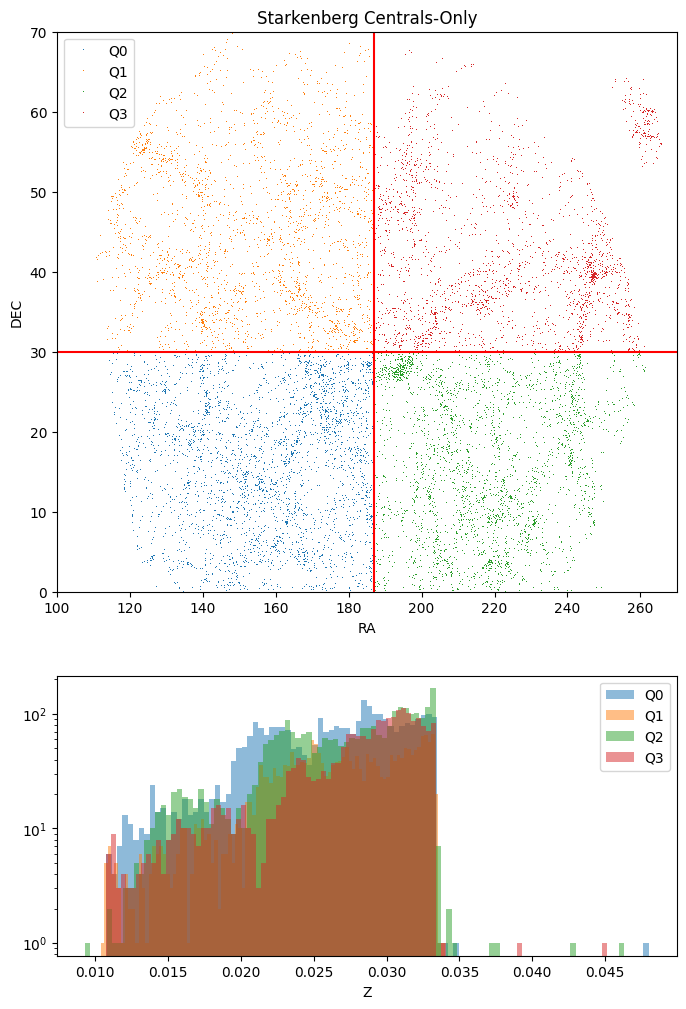

In [12]:
f = plt.figure(figsize=(8,12))
gs = f.add_gridspec(2,1, height_ratios=[1,0.5])

# tjitske
ax = f.add_subplot(gs[0])
for i in range(4):
    mask = datatj['bin'] == i
    ax.plot(datatj[mask]['RA'], datatj[mask]['DEC'], ',', alpha=1, label=f'Q{i}')
ax.legend()
ax.set_xlim(rae)
ax.set_ylim(dece)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title(f'Starkenberg Centrals-Only')
ax.axvline(ramid, color='r')
ax.axhline(decmid, color='r')

ax = f.add_subplot(gs[1])
for i in range(4):
    mask = datatj['bin'] == i
    ax.hist(datatj[mask]['Z'], bins=100, alpha=0.5, label=f'Q{i}')
ax.set_xlabel('Z')
ax.semilogy()
ax.legend()


In [13]:
# measure volume of each bin
for i in range(4):
    mask = datatj['bin'] == i
    vol = measure_volume(datatj['cX'][mask], datatj['cY'][mask], datatj['cZ'][mask])
    print(f'Q{i}: {np.sum(mask)} gals in ({vol**(1/3):.2f} Mpc/h)^3 = {np.sum(mask)/vol:.2e} gals/(Mpc/h)^3')

Q0: 3211 gals in (90.18 Mpc/h)^3 = 4.38e-03 gals/(Mpc/h)^3
Q1: 2381 gals in (79.31 Mpc/h)^3 = 4.77e-03 gals/(Mpc/h)^3
Q2: 2864 gals in (92.50 Mpc/h)^3 = 3.62e-03 gals/(Mpc/h)^3
Q3: 2231 gals in (86.07 Mpc/h)^3 = 3.50e-03 gals/(Mpc/h)^3


## Calculate and compare P(k)

In [14]:
# Calc P(k)
from summarizer.data import SurveyCatalogue

In [45]:
# import randoms

filename = pjoin(wdir, 'random', 'lss_random-0.dr72.fits')
with fits.open(filename) as f:
    print(f.info())
    random = f[1].data

random = pd.DataFrame(np.array([random[col] for col in random.dtype.names]).T, 
                      columns=random.dtype.names)

Filename: /home/mattho/git/ltu-cmass/data/obs/MGS/random/lss_random-0.dr72.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     25   1962944R x 4C   [D, D, J, E]   
None


In [46]:
# cut randoms
mask = (rae[0] < random['RA']) & (random['RA'] < rae[1]) 
mask &= (dece[0] < random['DEC']) & (random['DEC'] < dece[1])
random = random[mask]

mask = np.random.choice(len(random), 10*len(datatj), replace=False)
random = random.iloc[mask]

In [47]:
h, be = np.histogram(datatj['Z'], bins=100)
random['ZBIN'] = np.random.choice(np.arange(len(h)), size=len(random), p=h/h.sum())
random['Z'] = np.random.uniform(be[random['ZBIN']], be[random['ZBIN']+1], size=len(random))

106870

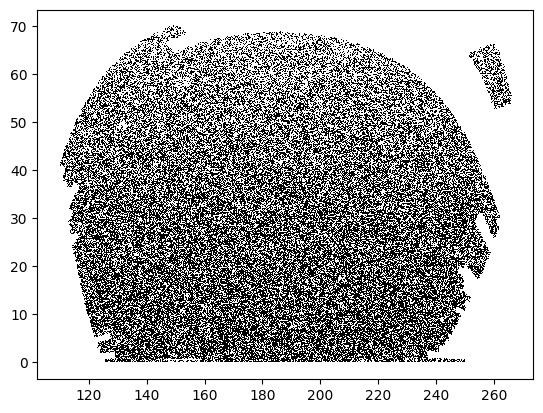

In [49]:
plt.plot(random['RA'], random['DEC'], 'k,', alpha=1)
len(random)

In [50]:
import numpy as np
from astropy.stats import scott_bin_width
from scipy.interpolate import InterpolatedUnivariateSpline
import nbodykit.lab as nblab

def get_nofz(z, fsky, cosmo=None):
    ''' calculate nbar(z) given redshift values and f_sky (sky coverage
    fraction)
    Parameters
    ----------
    z : array like
        array of redshift values 
    fsky : float 
        sky coverage fraction  
    cosmo : cosmology object 
        cosmology to calculate comoving volume of redshift bins 
    Returns
    -------
    number density at input redshifts: nbar(z) 
    Notes
    -----
    * based on nbdoykit implementation 
    '''
    # calculate nbar(z) for each galaxy
    _, edges = scott_bin_width(z, return_bins=True)

    dig = np.searchsorted(edges, z, "right")
    N = np.bincount(dig, minlength=len(edges)+1)[1:-1]

    R_hi = cosmo.comoving_distance(edges[1:])  # Mpc/h
    R_lo = cosmo.comoving_distance(edges[:-1])  # Mpc/h

    dV = (4./3.) * np.pi * (R_hi**3 - R_lo**3) * fsky

    nofz = InterpolatedUnivariateSpline(
        0.5*(edges[1:] + edges[:-1]), N/dV, ext='const')

    return nofz

In [51]:
grdz = np.array([datatj['RA'], datatj['DEC'], datatj['Z']]).T
rrdz = np.array([random['RA'], random['DEC'], random['Z']]).T

In [52]:

from nbodykit import cosmology

fsky = 6347 / (360.0**2 / np.pi)
cosmo = cosmology.Planck15  # fixed because we don't know true cosmology
ng_of_z = get_nofz(grdz[:, -1], fsky, cosmo=cosmo)
nbar_g = ng_of_z(grdz[:, -1])
nbar_r = ng_of_z(rrdz[:, -1])
weights = np.ones_like(nbar_g)

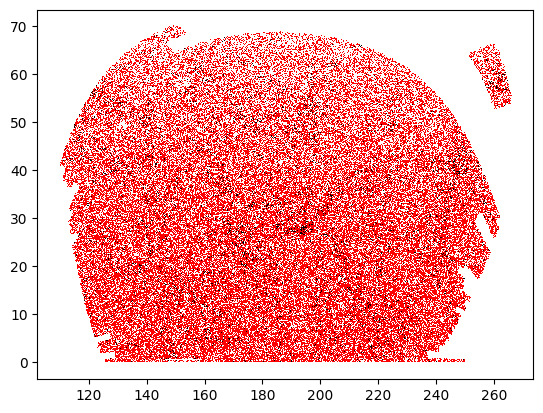

In [66]:
plt.plot(grdz[:,0], grdz[:,1], 'k,', alpha=1)
plt.plot(rrdz[:,0], rrdz[:,1], 'r,', alpha=1)

In [54]:
cat = SurveyCatalogue(grdz, rrdz, np.mean(grdz[:,-1]), nbar_g, nbar_r, cosmo, weights=weights)

INFO:FKPCatalog:cartesian coordinate range: [-1.07185695e+02 -9.37274044e+01  8.51978117e-03] : [-2.4923707  98.21204556 91.91289986]
INFO:FKPCatalog:BoxSize = [107. 196.  94.]
INFO:FKPCatalog:BoxCenter = [-54.83903278   2.24232057  45.96070982]


In [55]:
# from summarizer.two_point import Pk
mesh = cat.to_mesh(360)

INFO:FKPCatalog:cartesian coordinate range: [-1.07185695e+02 -9.37274044e+01  8.51978117e-03] : [-2.4923707  98.21204556 91.91289986]
INFO:FKPCatalog:BoxSize = [107. 196.  94.]
INFO:FKPCatalog:BoxCenter = [-54.83903278   2.24232057  45.96070982]


In [57]:
field = mesh.to_real_field()

INFO:CatalogMesh:Chunk 0 ~ 4194304 / 10687 
INFO:CatalogMesh:painted 10687 out of 10687 objects to mesh
INFO:CatalogMesh:painted 10687 out of 10687 objects to mesh
INFO:CatalogMesh:mean particles per cell is 1.40901e-06
/data80/mattho/anaconda3/envs/cmass/lib/python3.10/logging/__init__.py:368: ComplexWarning: Casting complex values to real discards the imaginary part
  msg = msg % self.args
INFO:CatalogMesh:sum is 65.7388 
INFO:FKPCatalogMesh:data painted.
INFO:CatalogMesh:Chunk 0 ~ 4194304 / 10687 
INFO:CatalogMesh:painted 10687 out of 10687 objects to mesh
INFO:CatalogMesh:painted 10687 out of 10687 objects to mesh
INFO:CatalogMesh:mean particles per cell is 1.40901e-06
/data80/mattho/anaconda3/envs/cmass/lib/python3.10/logging/__init__.py:368: ComplexWarning: Casting complex values to real discards the imaginary part
  msg = msg % self.args
INFO:CatalogMesh:sum is 65.7388 
INFO:FKPCatalogMesh:randoms painted.
INFO:FKPCatalogMesh:volume per cell is 0.0422533


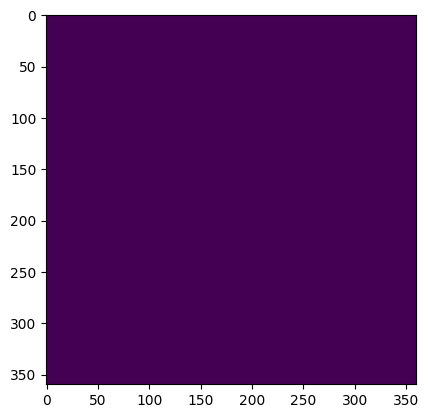

In [67]:
plt.imshow(field.value[200].real,)

In [39]:
mesh

(FKPCatalog(species=['data', 'randoms']) as CatalogMesh)

In [40]:
# runner = Pk()
# Pk = runner(cat)
r = nblab.ConvolvedFFTPower(mesh, poles=[0, 2, 4], dk=0.005, kmin=1)

k_gal = r.poles['k']
p0k_gal = r.poles['power_0'].real - r.attrs['shotnoise']
p2k_gal = r.poles['power_2'].real
p4k_gal = r.poles['power_4'].real

INFO:ConvolvedFFTPower:using compensation function CompensateTSCShotnoise for source 'first'
INFO:ConvolvedFFTPower:using compensation function CompensateTSCShotnoise for source 'second'


INFO:CatalogMesh:Chunk 0 ~ 4194304 / 10687 
INFO:CatalogMesh:painted 10687 out of 10687 objects to mesh
INFO:CatalogMesh:painted 10687 out of 10687 objects to mesh
INFO:CatalogMesh:mean particles per cell is 1.40901e-06
/data80/mattho/anaconda3/envs/cmass/lib/python3.10/logging/__init__.py:368: ComplexWarning: Casting complex values to real discards the imaginary part
  msg = msg % self.args
INFO:CatalogMesh:sum is 65.7388 
INFO:FKPCatalogMesh:data painted.
INFO:CatalogMesh:Chunk 0 ~ 4194304 / 10687 
INFO:CatalogMesh:painted 10687 out of 10687 objects to mesh
INFO:CatalogMesh:painted 10687 out of 10687 objects to mesh
INFO:CatalogMesh:mean particles per cell is 1.40901e-06
/data80/mattho/anaconda3/envs/cmass/lib/python3.10/logging/__init__.py:368: ComplexWarning: Casting complex values to real discards the imaginary part
  msg = msg % self.args
INFO:CatalogMesh:sum is 65.7388 
INFO:FKPCatalogMesh:randoms painted.
INFO:FKPCatalogMesh:volume per cell is 0.0422533
INFO:FKPCatalogMesh:fiel

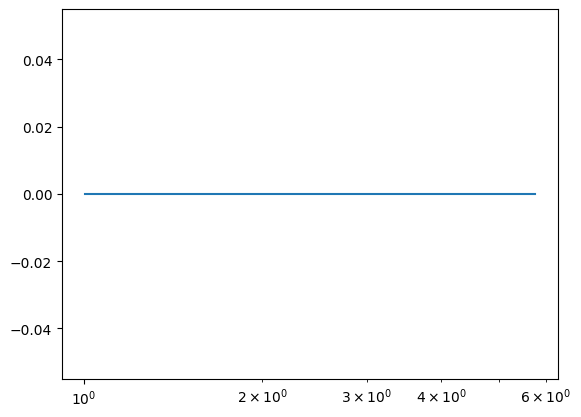

In [42]:
plt.semilogx()
plt.plot(k_gal, p2k_gal)

In [58]:
Pks = []
for i in range(4):
    mask = datatj['bin'] == i
    pos = np.array([datatj['cX'][mask], datatj['cY'][mask], datatj['cZ'][mask]]).T
    vel = np.zeros_like(pos)
    mass = np.ones_like(pos[:,0])

    cat = Catalogue(pos, vel=vel, mass=mass, redshift=datatj['Z'][mask].mean(), boxsize=0.150, cosmo_dict=None, name='test', mesh=True)
    Pk = runner(cat)
    Pks.append(Pk)

INFO:CatalogMesh:Chunk 0 ~ 4194304 / 3211 


INFO:CatalogMesh:painted 3211 out of 3211 objects to mesh
INFO:CatalogMesh:painted 3211 out of 3211 objects to mesh
INFO:CatalogMesh:mean particles per cell is 6.88229e-05
INFO:CatalogMesh:sum is 3211 
INFO:CatalogMesh:normalized the convention to 1 + delta
INFO:CatalogMesh:Chunk 0 ~ 4194304 / 3211 
INFO:CatalogMesh:painted 3211 out of 3211 objects to mesh
INFO:CatalogMesh:painted 3211 out of 3211 objects to mesh
INFO:CatalogMesh:mean particles per cell is 6.88229e-05
INFO:CatalogMesh:sum is 3211 
INFO:CatalogMesh:normalized the convention to 1 + delta
INFO:CatalogMesh:field: (ArrayCatalog(size=3211) as CatalogMesh) painting done
INFO:CatalogMesh:Chunk 0 ~ 4194304 / 2381 
INFO:CatalogMesh:painted 2381 out of 2381 objects to mesh
INFO:CatalogMesh:painted 2381 out of 2381 objects to mesh
INFO:CatalogMesh:mean particles per cell is 5.10331e-05
INFO:CatalogMesh:sum is 2381 
INFO:CatalogMesh:normalized the convention to 1 + delta
INFO:CatalogMesh:Chunk 0 ~ 4194304 / 2381 
INFO:CatalogMesh:p

Text(0.5, 1.0, 'Pk')

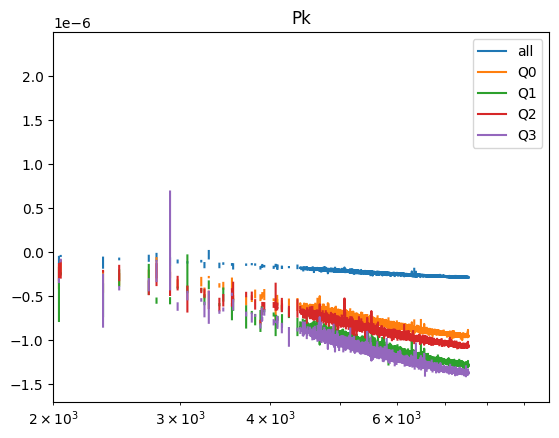

In [67]:
labels = ['all', 'Q0', 'Q1', 'Q2', 'Q3']
for i, Pk in enumerate([Pk0]+Pks):
    plt.plot(Pk[-1], Pk[0], label=labels[i])

plt.legend()
plt.semilogx()
plt.xlim(2e3)
plt.title('Pk')

## Prepare for Lucia and Tjitske